In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from plot import plotCorrelation, plotSignals
from misc import *

# Import own packages
import sys
sys.path.append("/mnt/c/Users/vmangr/Documents/Code/sydr/")
from sydr.utils.constants import GPS_L1CA_CODE_FREQ


### Create a GNSS signal

In [2]:
# Parameters
prn = 1
samplingFrequency = 10e6
cn0_target = 35
signal_bw = GPS_L1CA_CODE_FREQ # Bandwidth of the signal for CN0 to SNR computation
#quantization_bits = 8

# Generate signals
signal = generateGPSL1CA(prn=prn, samplingFrequency=samplingFrequency)
sigma_noise = getSigmaFromCN0(signal_power_dB=0, cn0_target_dB=cn0_target, signal_bw=signal_bw)
signal_noisy = addWhiteNoise(signal, sigma=sigma_noise)

# Quantization 
signal_quantized = quantize(signal_noisy, 1)

# Correct the mean
#signal_quantized = signal_quantized - np.mean(signal_quantized)

# Correlate
signal_corr, signal_lags = correlate(signal, signal)
signal_noisy_corr, signal_noisy_lags = correlate(signal, signal_noisy)
signal_quantized_corr, signal_quantized_lags = correlate(signal, signal_quantized)


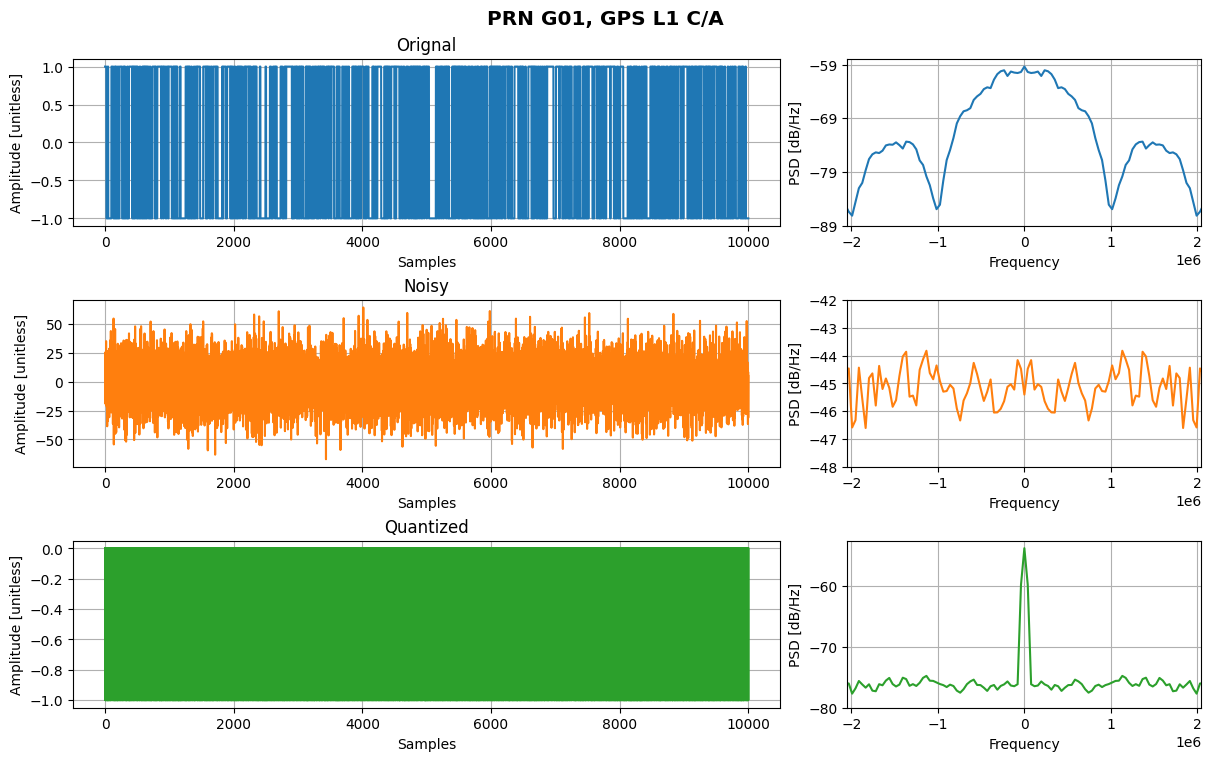

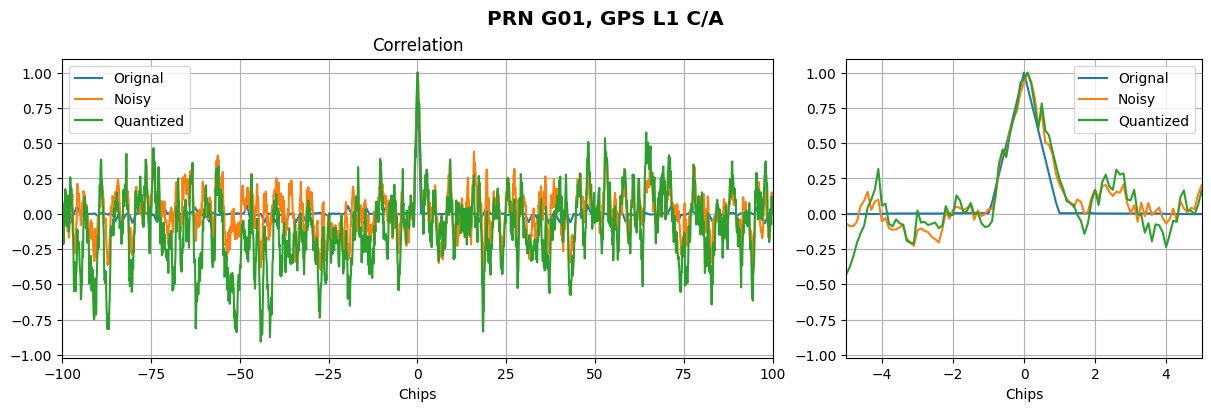

In [3]:

plotSignals({'Orignal' : signal, 'Noisy': signal_noisy, 'Quantized': signal_quantized}, 
            samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

plotCorrelation({'Orignal' : (signal_corr, signal_lags), 'Noisy': (signal_noisy_corr, signal_noisy_lags), 'Quantized': (signal_quantized_corr, signal_quantized_lags)}, 
                samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

In [4]:
len(np.unique(signal_quantized))

2